In [0]:
from google.colab import drive
drive.mount('/content/Drive')
!ls

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).
Drive  sample_data


In [0]:
import os
os.getcwd()

os.chdir('/content/Drive/My Drive/Colab Notebooks/Augmented1')

!ls  

 history.json			       Test	    vgg16_2.h5
'Raw VGG16.h5'			       Training     weights.best.hdf5
'Rotated - VGG - CNN(Augmented1).h5'   Validation


In [0]:
import keras
import numpy as np
from keras.applications import inception_v3

#Load the Inception_V3 model
conv_base = inception_v3.InceptionV3(weights='imagenet',
                                           include_top = False,
                                           input_shape=(150,150,3)) 


In [0]:
 conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir ='/content/Drive/My Drive/Colab Notebooks/Augmented1'
train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2597)
validation_features, validation_labels = extract_features(validation_dir, 1558)
test_features, test_labels = extract_features(test_dir, 1045)

Found 2597 images belonging to 2 classes.
Found 1558 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2597, 3*3* 2048))
validation_features = np.reshape(validation_features, (1558, 3*3* 2048))
test_features = np.reshape(test_features, (1045, 3*3* 2048))

In [0]:
from keras import models
from keras import layers
from keras import optimizers
import keras

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= 3*3* 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(train_features, train_labels,
epochs=100,
batch_size=20,
validation_data=(validation_features, validation_labels)
)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2597 samples, validate on 1558 samples
Epoch 1/100
2597/2597 [==============================] - 3s 1ms/step - loss: 0.7466 - acc: 0.5945 - val_loss: 0.5908 - val_acc: 0.6849
Epoch 2/100
2597/2597 [==============================] - 1s 392us/step - loss: 0.5665 - acc: 0.7074 - val_loss: 0.5628 - val_acc: 0.7144
Epoch 3/100
2597/2597 [==============================] - 1s 384us/step - loss: 0.4773 - acc: 0.7720 - val_loss: 0.4830 - val_acc: 0.7779
Epoch 4/100
2597/2597 [==============================] - 1s 395us/step - loss: 0.3977 - acc: 0.8271 - val_loss: 0.4563 - val_acc: 0.7965
Epoch 5/100
2597/2597 [==============================] - 1s 400us/step - loss: 0.3385 - acc: 0.8729 - val_loss: 0.4271 - val_acc: 0.8190
Epoch 6/100
2597/2597 [==============================] -

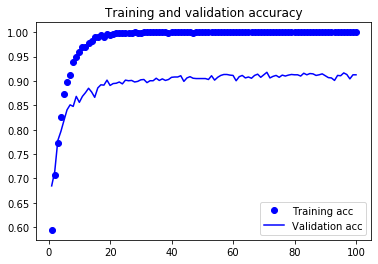

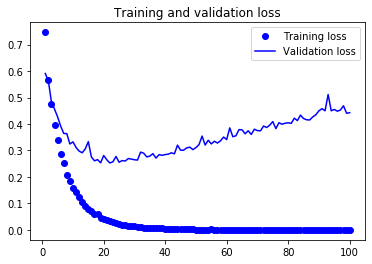

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 26,487,457
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=360,
  # width_shift_range=0.2,
  # height_shift_range=0.2,
  # shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
  validation_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

model.compile(loss='binary_crossentropy',
  optimizer=optimizers.RMSprop(lr=2e-5),
  metrics=['acc'])

history = model.fit_generator(
  train_generator,
  steps_per_epoch=100,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=10)

Found 2597 images belonging to 2 classes.
Found 1558 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 52s 519ms/step - loss: 0.7269 - acc: 0.5379 - val_loss: 0.6248 - val_acc: 0.6850
Epoch 2/30
100/100 [==============================] - 35s 351ms/step - loss: 0.6432 - acc: 0.6473 - val_loss: 0.5452 - val_acc: 0.7300
Epoch 3/30
100/100 [==============================] - 36s 363ms/step - loss: 0.5881 - acc: 0.6947 - val_loss: 0.5869 - val_acc: 0.7150
Epoch 4/30
100/100 [==============================] - 37s 365ms/step - loss: 0.5239 - acc: 0.7370 - val_loss: 0.5268 - val_acc: 0.7450
Epoch 5/30
100/100 [==============================] - 36s 364ms/step - loss: 0.4761 - acc: 0.7832 - val_loss: 0.3127 - val_acc: 0.8600
Epoch 6/30
100/100 [==============================] - 36s 364ms/step - loss: 0.4169 - acc: 0.8025 - val_loss: 0.3682 - val_acc: 0.8250
Epoch 7/30
100/100 [==============================] - 36s 364ms/step - loss: 0.3398 - acc: 0.8514 - val_lo

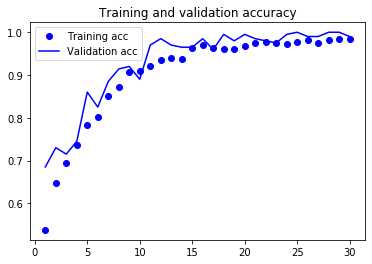

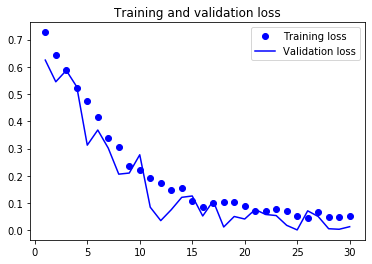

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [0]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1045 images belonging to 2 classes.
test acc: 0.9989999997615814


In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("Inception_v3 - Raw - CNN.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=20, 
                      verbose=1, 
                      mode='auto')


model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks = [checkpoint, early])


Epoch 1/50
100/100 [==============================] - 54s 542ms/step - loss: 0.0468 - acc: 0.9855 - val_loss: 0.0078 - val_acc: 0.9970

Epoch 00001: val_acc improved from -inf to 0.99700, saving model to Inception_v3 - Raw - CNN.h5
Epoch 2/50
100/100 [==============================] - 42s 418ms/step - loss: 0.0396 - acc: 0.9859 - val_loss: 0.0211 - val_acc: 0.9920

Epoch 00002: val_acc did not improve from 0.99700
Epoch 3/50
100/100 [==============================] - 43s 431ms/step - loss: 0.0383 - acc: 0.9845 - val_loss: 0.0081 - val_acc: 0.9970

Epoch 00003: val_acc did not improve from 0.99700
Epoch 4/50
100/100 [==============================] - 44s 440ms/step - loss: 0.0396 - acc: 0.9860 - val_loss: 0.0150 - val_acc: 0.9940

Epoch 00004: val_acc did not improve from 0.99700
Epoch 5/50
100/100 [==============================] - 43s 429ms/step - loss: 0.0329 - acc: 0.9880 - val_loss: 0.0049 - val_acc: 0.9980

Epoch 00005: val_acc improved from 0.99700 to 0.99800, saving model to Inc

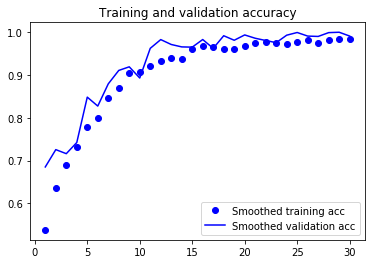

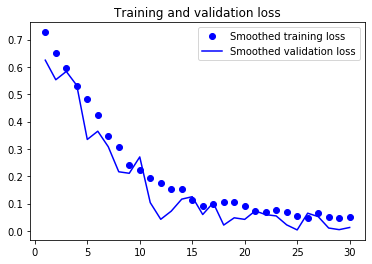

In [0]:
def smooth_curve(points, factor=0.1):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
        smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
  smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
  smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
  smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
  smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1045 images belonging to 2 classes.
test acc: 1.0


In [0]:
# load_model_sample.py
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # load model
    model = load_model("Inception_v3 - Raw - CNN.h5")

    # image path
    # img_path = '/content/Drive/My Drive/Colab Notebooks/data01/Test/mdb226.jpg'    # benign
    img_path = '/content/Drive/My Drive/Colab Notebooks/data01/Test/mdb241.jpg'      # malignant

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict(new_image)
    print (pred)

[[0.9999989]]
